In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from led_array.bsccm_utils import *
from plot_utils import *
from led_array.bsccm_utils import *
from image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Show stationary process approximation

In [64]:
N_images = 100000
patch_size = 50
edge_crop = 24

photons_per_pixel = 150
# channel = 'DPC_Right'
channel = 'LED119'

images = load_bsccm_images(bsccm, channel, num_images=N_images, convert_units_to_photons=True, edge_crop=edge_crop)
images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))

N_patches = 100000
patches = extract_patches(images, patch_size=patch_size, num_patches=N_patches)

100%|██████████| 100000/100000 [00:00<00:00, 432218.89it/s]


computing cov mat


100%|██████████| 99/99 [00:04<00:00, 23.42it/s]


making positive definite
Matrix not positive definite. Adding 32.82396697998047 to eigenvalues


precomputing masks and variances: 100%|██████████| 50/50 [00:05<00:00,  8.52it/s]


generating samples


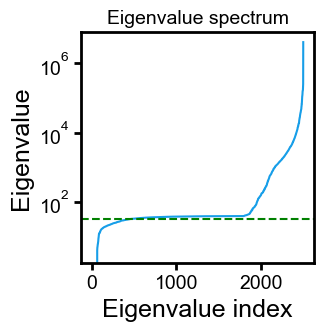

In [67]:
sample_size = patch_size    
num_images_to_show = 3

print('computing cov mat')
cov_mat = compute_stationary_cov_mat(patches)
print('making positive definite')
cov_mat = make_positive_definite(cov_mat, cutoff_percentile=20, show_plot=True)
# cov_mat = compute_cov_mat(patches) # non-stationary version
samples = generate_stationary_gaussian_process_samples(cov_mat, sample_size, num_images_to_show, 
        prefer_iterative_sampling=False, mean=np.mean(patches), seed=123344)

100%|██████████| 1/1 [00:00<00:00, 13751.82it/s]


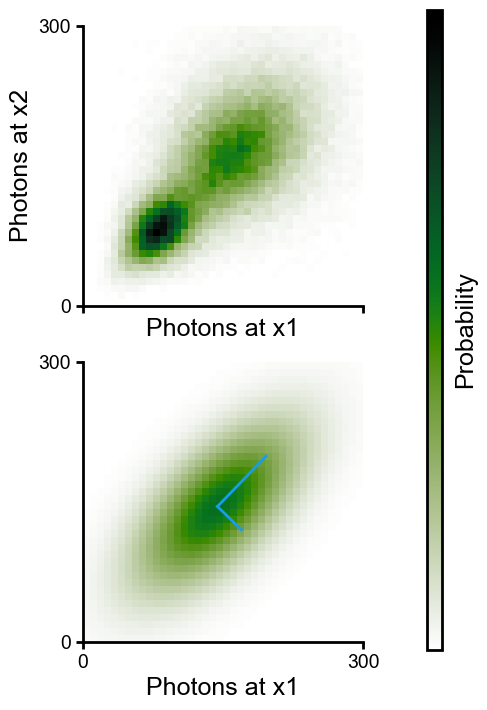

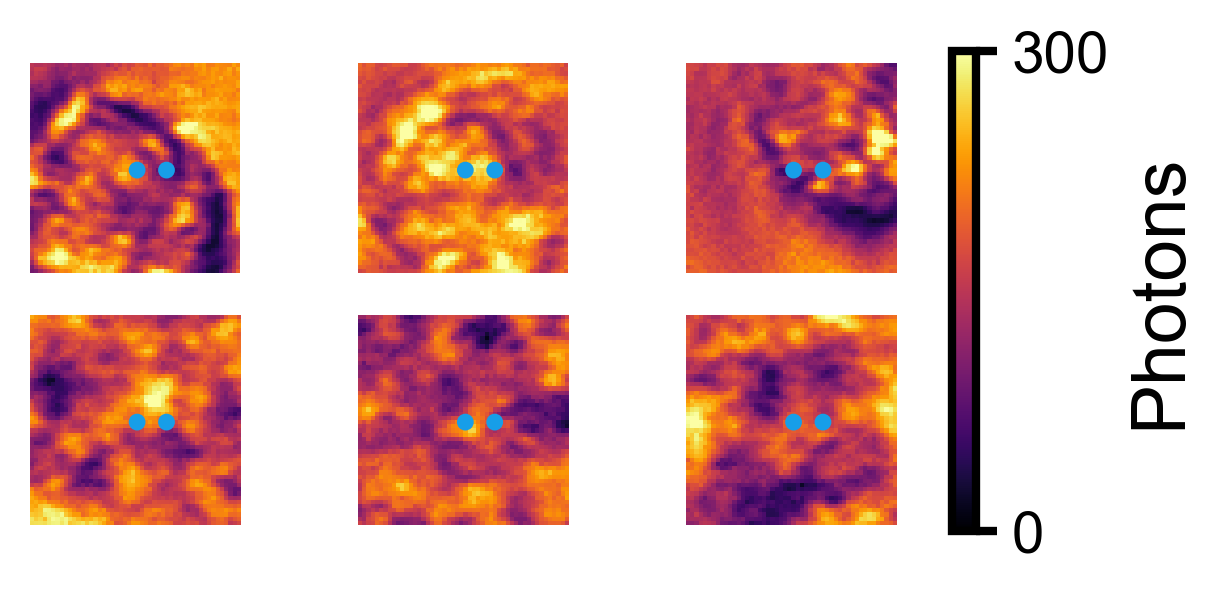

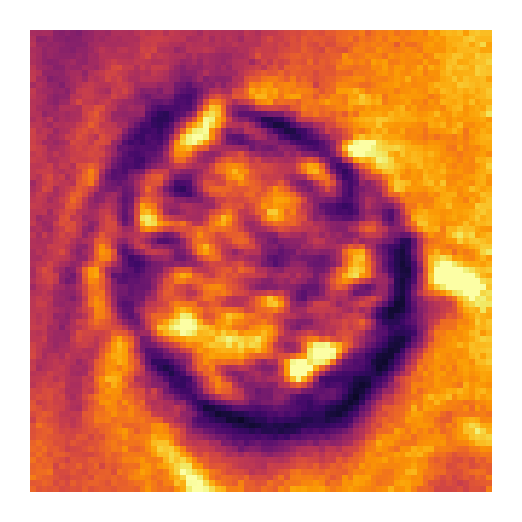

In [69]:
from scipy.stats import multivariate_normal
import cmasher as cmr
import cmocean as cm
from matplotlib.patches import Circle
from matplotlib.cm import ScalarMappable


display_image_indices = np.arange(11, 20)

patches_for_display = [extract_patches(images[index].reshape(1, *images.shape[1:]),
                                        patch_size, num_patches=1)[0] for index in display_image_indices]


x2_offset = (0, 7)
x1_position = (patches.shape[1] // 2, patches.shape[2] // 2)


display_lim = (0, 300)
# display_lim = (60, 230)

num_bins = 40
cmap = cmr.jungle.reversed()
color = get_color_cycle()[0]
bins = np.linspace(*display_lim, num_bins + 1)


x1_samples= patches[:, x1_position[0], x1_position[1]]
x2_samples = patches[:, x1_position[0] + x2_offset[0], x1_position[1] + x2_offset[1]]

# plot a a 2d historgram empirical distribution
p_x, yedges, xedges = np.histogram2d(x2_samples, x1_samples, bins=bins)
p_x /= p_x.sum()

design = np.stack([x1_samples, x2_samples], axis=1)
# compute mean and covariance
mean = np.mean(design, axis=0)
cov = np.cov(design.T)

gaussian_pdf = multivariate_normal.pdf(np.stack(
    np.meshgrid(np.linspace(*display_lim, num_bins), np.linspace(*display_lim, num_bins)), axis=-1),  mean=mean, cov=cov)
gaussian_pdf /= gaussian_pdf.sum()

# compute vmin and vmax for both plots
vmin = onp.min([p_x, gaussian_pdf])
vmax = onp.max([p_x, gaussian_pdf])

fig_dist, ax_dist = plt.subplots(2, 1, figsize=(5, 8 ), sharex=True, sharey=True)
# plot a a 2d historgram of the design matrix
ax_dist[0].imshow(p_x, cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
clear_spines(ax_dist[0])
ax_dist[0].set(xticks=display_lim, yticks=display_lim, xlabel='Photons at x1', ylabel='Photons at x2')

# make another plot showing the PDF of the Gaussian
ax_dist[1].imshow(gaussian_pdf, 
    cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
# draw the major and minor axes of the ellipse
eigvals, eigvecs = np.linalg.eigh(cov)
# plot them
for eigval, eigvec in zip(np.sqrt(eigvals), eigvecs.T):
    ax_dist[1].plot([mean[0], mean[0] +  eigval * eigvec[0]], [mean[1], mean[1] +  eigval * eigvec[1]], color=color, linewidth=2)
# same formatting as before
clear_spines(ax_dist[1])
ax_dist[1].set(xticks=display_lim, yticks=display_lim, xlabel='Photons at x1')

fig_img, ax_img = plt.subplots(2, 3, figsize=(4, 2), dpi=300)
for i in range(num_images_to_show):
    image = patches_for_display[i]
    ax_img[0, i].imshow(image, cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
    ax_img[0, i].axis('off')
    ax_img[0, i].add_patch(Circle((x1_position[1], x1_position[0]), 1.5, color=color))
    ax_img[0, i].add_patch(Circle((x1_position[1] + x2_offset[1], x1_position[0] + x2_offset[0]), 1.5, color=color))

    ax_img[1, i].imshow(samples[i], cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
    ax_img[1, i].axis('off')
    ax_img[1, i].add_patch(Circle((x1_position[1], x1_position[0]), 1.5, color=color))
    ax_img[1, i].add_patch(Circle((x1_position[1] + x2_offset[1], x1_position[0] + x2_offset[0]), 1.5, color=color))


# add a colorbar
fig_img.subplots_adjust(right=0.9)
cbar_ax = fig_img.add_axes([0.92, 0.1, 0.02, 0.8])
sm = ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=display_lim[0], vmax=display_lim[1]))
fig_img.colorbar(sm, cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=display_lim,  ylabel='Photons')
fig_img.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'gaussian_approx_patches' + '.pdf', transparent=True, dpi=600)


# add a colorbar
fig_dist.subplots_adjust(right=0.9)
cbar_ax = fig_dist.add_axes([0.92, 0.1, 0.03, 0.8])
fig_dist.colorbar(ScalarMappable(cmap=cmap), cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=[],  ylabel='Probability')

# fig_dist.suptitle(f'x1 = {x1_position}, x2 = {x1_position} + {x2_offset}')

fig_dist.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'px_gaussian_approx_gaussian' + '.pdf', transparent=True, dpi=600)




fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)
ax.imshow(images[display_image_indices[0]], cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
ax.axis('off')
fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'gaussian_approx_images' + '.pdf', transparent=True, dpi=600)

## show channel

In [61]:
num_noisy_images_for_histogram = 50000
single_patch = patches[1]
point_offset = (0, 7)
clean_intensity = (single_patch[single_patch.shape[0] // 2, single_patch.shape[1] // 2], 
                    single_patch[single_patch.shape[0] // 2 + point_offset[0] // 2, single_patch.shape[1] // 2 + point_offset[1] // 2])

intensity_samples_1 = []
intensity_samples_2 = []
noisy_patches = np.stack([add_shot_noise(single_patch) for i in tqdm(range(num_noisy_images_for_histogram))], axis=0)
intensity_samples_1.append(noisy_patches[:, noisy_patches.shape[1] // 2, noisy_patches.shape[2] // 2].flatten())
intensity_samples_2.append(noisy_patches[:, noisy_patches.shape[1] // 2 + point_offset[0] // 2, 
                                        noisy_patches.shape[2] // 2 + point_offset[1] // 2].flatten())

100%|██████████| 50000/50000 [00:19<00:00, 2586.37it/s]


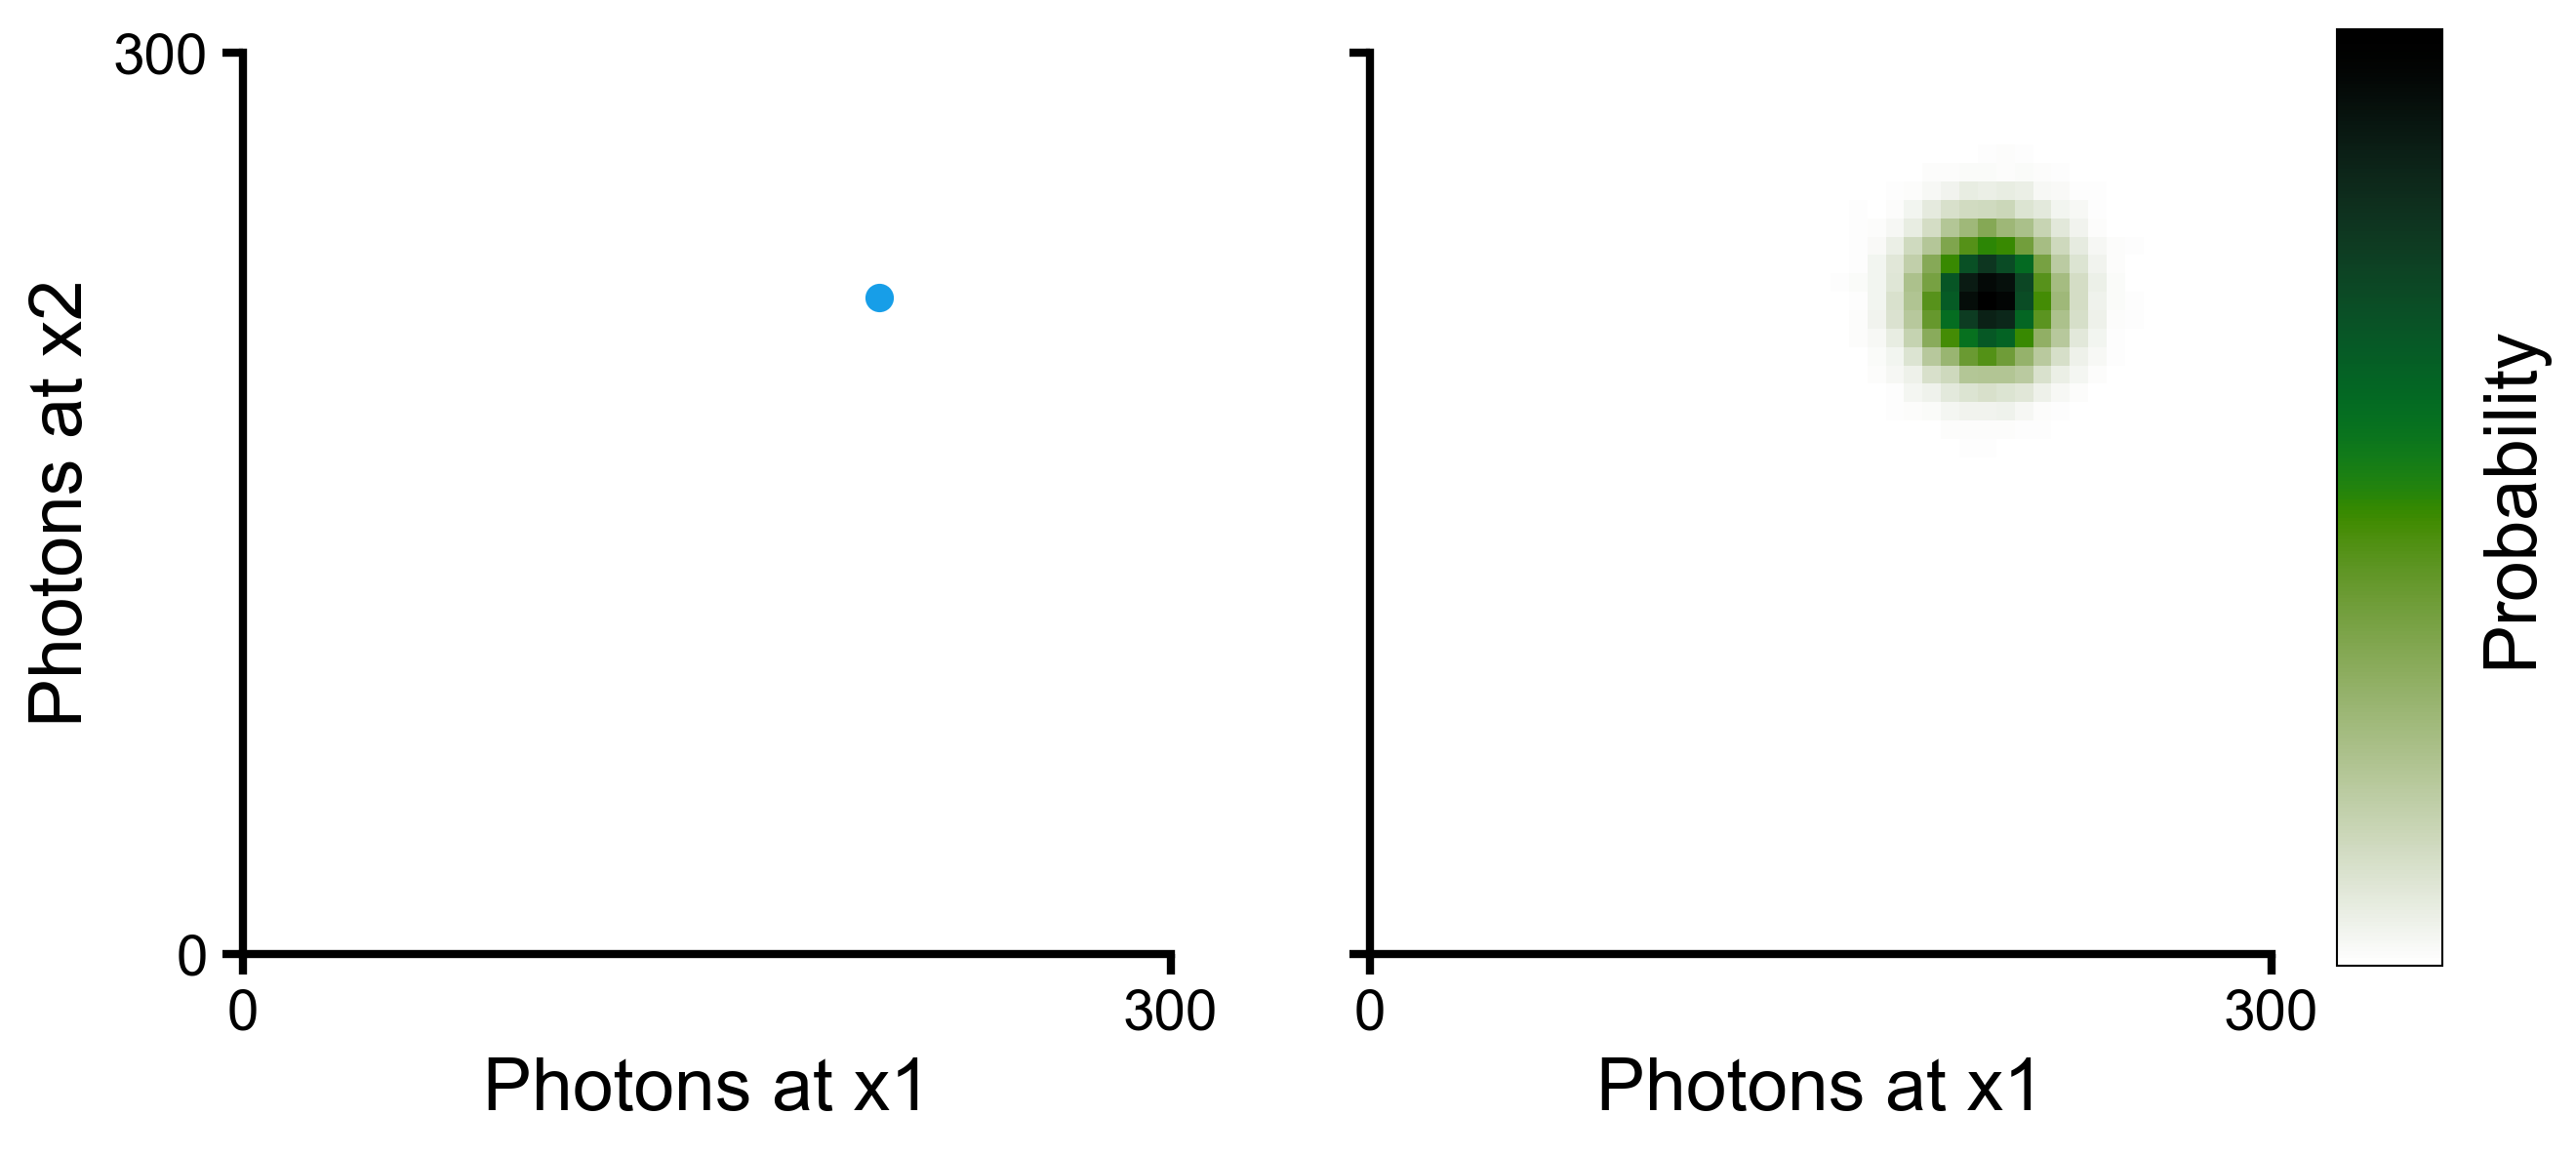

In [63]:
cmap = cmr.jungle.reversed()

fig, ax = plt.subplots(1, 2, figsize=(9, 4), dpi=300, sharex=True, sharey=True)

ax[0].plot(clean_intensity[0], clean_intensity[1], 'o', color=get_color_cycle()[0])
clear_spines(ax[0])
ax[0].set(xlabel='Photons at x1', ylabel='Photons at x2')

plot_intensity_coord_histogram(ax[1], intensity_samples_1, intensity_samples_2, display_lim[1], 
                                 bins=50, cmap=cmap)
ax[1].set(ylabel=None)

fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'conditional histogram' + '.pdf', transparent=True)

100%|██████████| 1/1 [00:00<00:00, 6626.07it/s]


100%|██████████| 3/3 [00:00<00:00, 323.92it/s]


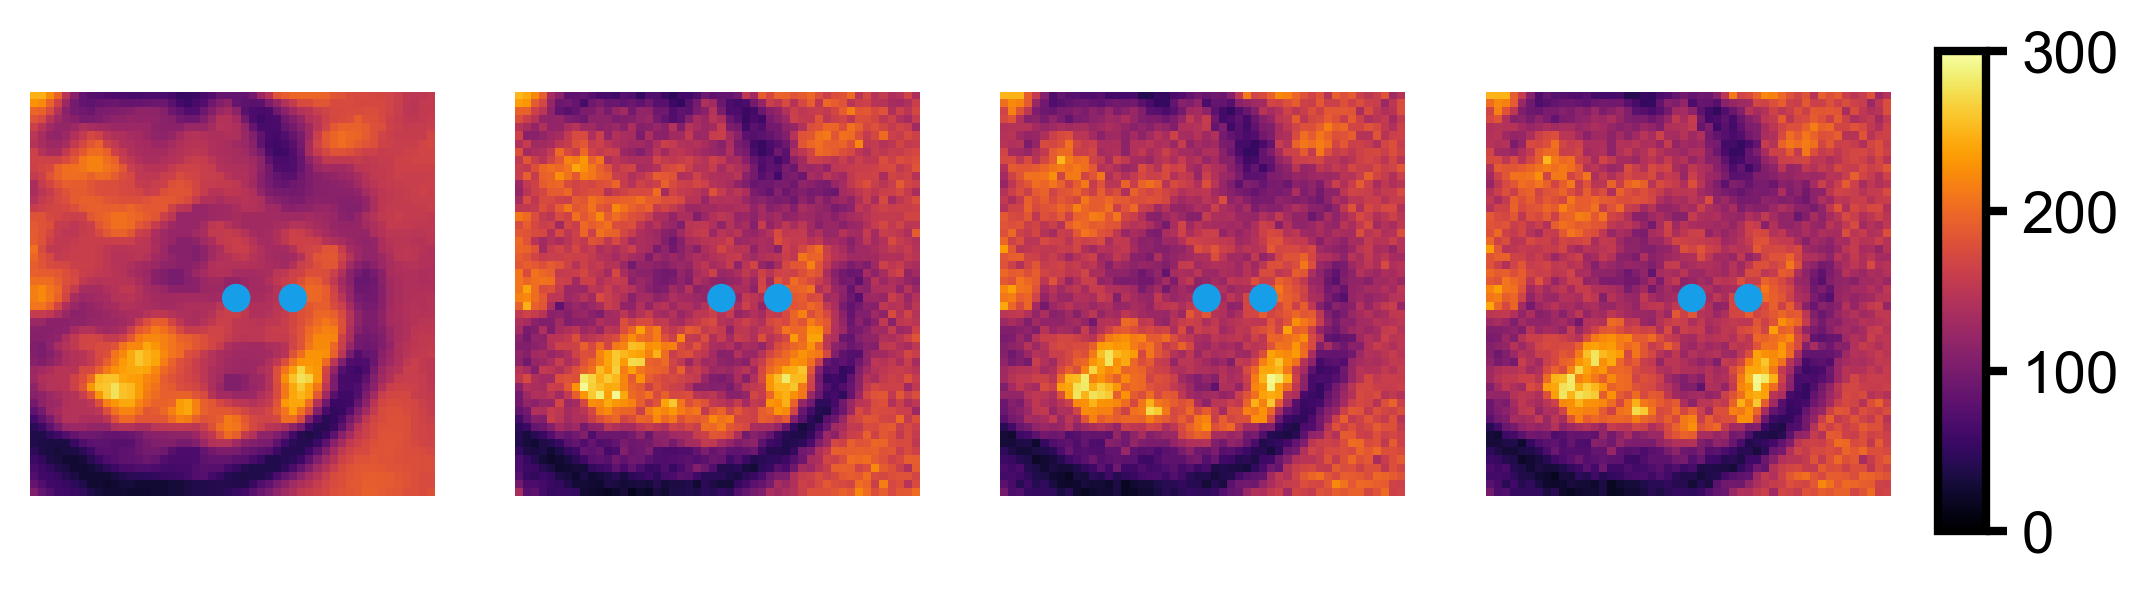

: 

In [101]:
image = load_bsccm_images(bsccm, channel, indices=[27], convert_units_to_photons=True, edge_crop=edge_crop, median_filter=True)[0]
patch_to_use = extract_patches(image.reshape(1, *image.shape), patch_size, num_patches=1)[0]

images = load_bsccm_images(bsccm, channel, num_images=1000, convert_units_to_photons=True, edge_crop=edge_crop, median_filter=False)
patch_to_use *= photons_per_pixel / np.mean(images)
# make noisy_patches_for_display
noisy_patches = np.stack([add_shot_noise(patch_to_use) for i in tqdm(range(num_images_to_show))], axis=0)


# plot the single patch and some noisy realizations of it
fig, ax = plt.subplots(1, 4, figsize=(8, 2), dpi=300)
ax[0].imshow(patch_to_use, cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
ax[0].axis('off')
ax[0].add_patch(Circle((patch_to_use.shape[1] // 2, patch_to_use.shape[0] // 2), 1.5, color=color))
ax[0].add_patch(Circle((patch_to_use.shape[1] // 2 + point_offset[1], patch_to_use.shape[0] // 2 + point_offset[0]), 1.5, color=color))

for i in range(1, 4):
    ax[i].imshow(noisy_patches[i], cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
    ax[i].axis('off')
    ax[i].add_patch(Circle((patch_to_use.shape[1] // 2, patch_to_use.shape[0] // 2), 1.5, color=color))
    ax[i].add_patch(Circle((patch_to_use.shape[1] // 2 + point_offset[1], patch_to_use.shape[0] // 2 + point_offset[0]), 1.5, color=color))

# add color scale bar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
sm = ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=display_lim[0], vmax=display_lim[1]))
fig.colorbar(sm, cax=cbar_ax)

# save
fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'noisy_patches' + '.pdf', transparent=True, dpi=600)